# <center><u>Analysis of Climate Change and Natural Disasters</u></center>

## Introduction

This project entails getting data from the National Oceanic and Atmospheric Administration (NOAA) and the Emergency Events Database (EM-DAT), for weather data and natural disasters data respectively, creating a database to store the data, and analyzing the data with this notebook.

In [2]:
# Import libraries

import os
from dotenv import load_dotenv
import psycopg2
from psycopg2.extras import DictCursor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

/Users/chuckschultz/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Function that connects to database

load_dotenv()
def db_connect():
    db_name = os.environ['db_name']
    db_user = os.environ['db_user']
    db_host = os.environ['db_host']
    db_credentials = os.environ['db_creds']
  
    conn_string = "dbname='" + str(db_name) + "' user='" + str(db_user) + "' host='" + str(db_host) + "' password='" + str(db_credentials) + "'"

    try:
        conn = psycopg2.connect(str(conn_string))
        conn.autocommit = True
    except:
        print("Unable to connect to the database")

    cur = conn.cursor(cursor_factory=DictCursor)
    return cur

cur = db_connect()

## Weather Data

Data from NOAA is from 1950 to 2020. There are over 118,000 stations worldwide. I used a clustering algorithm (DBSCAN) to reduce the number of stations geographically, choosing stations with the highest data coverage. The stations are ~1000 kilometers from each other, reducing the number of chosen stations to 276. For climate change, it is typical to use the 30 year average from 1951 to 1980 as a baseline for comparison. Temperature anomaly is then calculated as the difference between temperature and the 30 year average. I added 'tavg' (average temperature) and 'tanm' (temperature anomaly) features and then averaged each type of weather per day for each region and overall. There are just over 17.5 million weather records in the database.

<u>Features</u><br>
'tmin' - Minimum Temperature<br>
'tmax' - Maximum Temperature<br>
'tavg' - Average Temperature<br>
'prcp' - Precipitation<br>
'snow' - Snowfall<br>
'snwd' - Snow Depth<br>
'tanm' - Temperature Anomaly

### Load Weather Data into DataFrames

In [4]:
# Daily averages of each type of weather 1950-2020

query = "SELECT * \
    FROM weather.weather_full \
    WHERE extract(year from date) < 2021 \
    ORDER BY date"
cur.execute(query)
results = cur.fetchall()

weather_df_daily = pd.DataFrame(results, columns=['date','tmin','tmax','tavg','prcp','snow','snwd','tanm']).set_index(['date'])
weather_df_daily.head()

,tmin,tmax,tavg,prcp,snow,snwd,tanm
date,,,,,,,
1950-01-01,25.026087,42.292035,33.659061,0.061280,0.458065,3.162500,-18.325695
1950-01-02,23.684211,41.309735,32.496973,0.056587,0.623333,3.821739,-19.487784
1950-01-03,21.530973,38.912281,30.221627,0.051587,0.751613,4.079167,-21.763129
1950-01-04,20.289474,38.292035,29.290755,0.051575,0.345161,4.388000,-22.694002
1950-01-05,20.421053,37.280702,28.850877,0.050476,0.103226,4.488000,-23.133879


In [5]:
# Yearly averages for each type of weather 1950-2020

query = "SELECT (extract(year from date))::int as year, AVG(tmin), AVG(tmax), AVG(tavg), AVG(prcp), AVG(snow), AVG(snwd), AVG(tanm) \
    FROM weather.weather_full \
    WHERE extract(year from date) < 2021 \
    GROUP BY year \
    ORDER BY year"
cur.execute(query)
results = cur.fetchall()

weather_df = pd.DataFrame(results, columns=['year','tmin','tmax','tavg','prcp','snow','snwd','tanm']).set_index(['year'])
weather_df.head()

,tmin,tmax,tavg,prcp,snow,snwd,tanm
year,,,,,,,
1950,39.271125,56.642800,47.956962,0.084971,0.124971,2.138802,-4.027794
1951,42.307065,59.907361,51.107213,0.099155,0.119240,1.586048,-0.877544
1952,43.185232,60.292222,51.738727,0.101761,0.095212,1.360583,-0.246030
1953,43.867304,60.997787,52.432545,0.103087,0.082973,0.777744,0.447789
1954,43.456859,60.494445,51.975652,0.115209,0.095816,1.254132,-0.009104


In [6]:
# 30 year average temperature 1951-1980 (typically used to show trends in climate change)

temp_average = weather_df.loc[1951:1980]['tavg'].mean()
temp_average

51.98483538727068

In [7]:
# 30 year average precipitation 1951-1980

precip_average = weather_df.loc[1951:1980]['prcp'].mean()
precip_average

0.10391985236908731

In [8]:
# Yearly averages for each type of weather - Northern America 1950-2020

query = "SELECT (extract(year from date))::int as year, AVG(tmin), AVG(tmax), AVG(tavg), AVG(prcp), AVG(snow), AVG(snwd), AVG(tanm) \
    FROM weather.weather_northern_america \
    WHERE extract(year from date) < 2021 \
    GROUP BY year \
    ORDER BY year"
cur.execute(query)
results = cur.fetchall()

weather_northern_america_df = pd.DataFrame(results, columns=['year','tmin','tmax','tavg','prcp','snow','snwd','tanm']).set_index(['year'])
weather_northern_america_df.head()

,tmin,tmax,tavg,prcp,snow,snwd,tanm
year,,,,,,,
1950,29.023623,46.883599,37.953611,0.075931,0.142028,2.329827,1.175755
1951,29.528289,47.036603,38.282446,0.082244,0.139145,1.641673,1.504591
1952,29.739999,47.073468,38.406734,0.072556,0.117672,1.635467,1.628878
1953,29.957369,47.274450,38.615910,0.071356,0.104284,1.093829,1.838054
1954,30.084352,47.932166,39.008259,0.077216,0.117665,1.488721,2.230404


In [9]:
# 30 year average temperature - Northern America 1951-1980

mean_average_america = weather_northern_america_df.loc[1951:1980]['tavg'].mean()
mean_average_america

36.77798768881553

## Disaster Data

Data from EM-DAT is from 1900 to 2020. There are many features in this data, so I only chose the features needed for this analysis. I added the country_code feature. The damages feature is not adjusted for inflation or GDP for the country it occurred in. There are just over 16,000 natural disasters in the database.

<u>Features</u><br>
'year' - Year of Disaster<br>
'month' - Month of Disaster<br>
'country_code' - Two Character Country Code (ISO Alpha-2)<br>
'region' - 23 Geographical Areas of the World<br>
'disaster_type' - Type of Disaster<br>
'deaths' - Deaths from the Disaster<br>
'damages' - Damages from the Disaster

### Load Disaster Data into DataFrames

In [10]:
# Individual disasters

query = "SELECT year, month, country_code, region, disaster_type, deaths, damages \
    FROM weather.disasters_clean \
    WHERE year < 2021 \
    ORDER BY year, month"
cur.execute(query)
results = cur.fetchall()

disaster_df = pd.DataFrame(results, columns=['year','month','country_code','region','disaster_type','deaths','damages'])
disaster_df.head()

,year,month,country_code,region,disaster_type,deaths,damages
0,1900,1.0,JM,Caribbean,Epidemic,30.0,NaN
1,1900,1.0,JM,Caribbean,Flood,300.0,NaN
2,1900,7.0,JP,Eastern Asia,Volcanic activity,30.0,NaN
3,1900,7.0,TR,Western Asia,Earthquake,140.0,NaN
4,1900,9.0,US,Northern America,Storm,6000.0,30000.0


In [11]:
# Yearly number of disasters by region

disaster_df_region = disaster_df.value_counts(subset=['year', 'region']).to_frame(name='count').reset_index()
disaster_df_region = disaster_df_region.pivot(index='year', columns='region', values='count')
disaster_df_region.fillna(value=0, inplace=True)
disaster_df_region.head()

region,Australia and New Zealand,Caribbean,Central America,Central Asia,Eastern Africa,Eastern Asia,Eastern Europe,Melanesia,Micronesia,Middle Africa,...,Polynesia,Russian Federation,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe
year,,,,,,,,,,,,,,,,,,,,,
1900,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1901,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,2.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1903,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0
1904,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [12]:
# Yearly number of deaths by region

disaster_df_death_region = disaster_df[['year', 'region', 'deaths']].groupby(by=['year', 'region']).sum().reset_index()
disaster_df_death_region = disaster_df_death_region.pivot(index='year', columns='region', values='deaths')
disaster_df_death_region.fillna(value=0, inplace=True)
disaster_df_death_region.head()

region,Australia and New Zealand,Caribbean,Central America,Central Asia,Eastern Africa,Eastern Asia,Eastern Europe,Melanesia,Micronesia,Middle Africa,...,Polynesia,Russian Federation,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe
year,,,,,,,,,,,,,,,,,,,,,
1900,0.0,330.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1250000.0,0.0,11000.0,140.0,0.0
1901,0.0,0.0,0.0,0.0,200000.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,31565.0,9000.0,0.0,0.0,2625.0,0.0,0.0,0.0,0.0,...,0.0,4562.0,0.0,600.0,0.0,0.0,0.0,0.0,86.0,0.0
1903,0.0,65.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,350.0,0.0,0.0,6280.0,0.0
1904,0.0,0.0,0.0,0.0,0.0,148.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [13]:
# Yearly amount of damages by region

disaster_df_damages_region = disaster_df[['year', 'region', 'damages']].groupby(by=['year', 'region']).sum().reset_index()
disaster_df_damages_region = disaster_df_damages_region.pivot(index='year', columns='region', values='damages')
disaster_df_damages_region.fillna(value=0, inplace=True)
disaster_df_damages_region.head()

region,Australia and New Zealand,Caribbean,Central America,Central Asia,Eastern Africa,Eastern Asia,Eastern Europe,Melanesia,Micronesia,Middle Africa,...,Polynesia,Russian Federation,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe
year,,,,,,,,,,,,,,,,,,,,,
1900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Yearly number of deaths by disaster type

disaster_df_death_type = disaster_df[['year', 'disaster_type', 'deaths']].groupby(by=['year', 'disaster_type']).sum().reset_index()
disaster_df_death_type = disaster_df_death_type.pivot(index='year', columns='disaster_type', values='deaths')
disaster_df_death_type.drop(['Impact'], axis=1, inplace=True)
disaster_df_death_type.fillna(value=0, inplace=True)
disaster_df_death_type.head()

disaster_type,Animal accident,Complex Disasters,Drought,Earthquake,Epidemic,Extreme temperature,Flood,Fog,Insect infestation,Landslide,Mass movement (dry),Storm,Volcanic activity,Wildfire
year,,,,,,,,,,,,,,
1900,0.0,0.0,1261000.0,140.0,30.0,0.0,300.0,0.0,0.0,0.0,0.0,6000.0,30.0,0.0
1901,0.0,0.0,0.0,18.0,200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.0,9148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,38690.0,0.0
1903,0.0,0.0,0.0,6630.0,0.0,0.0,250.0,0.0,0.0,0.0,76.0,163.0,17.0,0.0
1904,0.0,0.0,0.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Yearly amount of damages by disaster type

disaster_df_damages_type = disaster_df[['year', 'disaster_type', 'damages']].groupby(by=['year', 'disaster_type']).sum().reset_index()
disaster_df_damages_type = disaster_df_damages_type.pivot(index='year', columns='disaster_type', values='damages')
disaster_df_damages_type.drop(['Impact'], axis=1, inplace=True)
disaster_df_damages_type.fillna(value=0, inplace=True)
disaster_df_damages_type.head()

disaster_type,Animal accident,Complex Disasters,Drought,Earthquake,Epidemic,Extreme temperature,Flood,Fog,Insect infestation,Landslide,Mass movement (dry),Storm,Volcanic activity,Wildfire
year,,,,,,,,,,,,,,
1900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30000.0,0.0,0.0
1901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1903,0.0,0.0,0.0,0.0,0.0,0.0,480000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Yearly number of disasters by disaster type

disaster_df_type = disaster_df.value_counts(subset=['year', 'disaster_type']).to_frame(name='count').reset_index()
disaster_df_type = disaster_df_type.pivot(index='year', columns='disaster_type', values='count')
disaster_df_type.drop(['Impact'], axis=1, inplace=True)
disaster_df_type.fillna(value=0, inplace=True)
disaster_df_type.head()

disaster_type,Animal accident,Complex Disasters,Drought,Earthquake,Epidemic,Extreme temperature,Flood,Fog,Insect infestation,Landslide,Mass movement (dry),Storm,Volcanic activity,Wildfire
year,,,,,,,,,,,,,,
1900,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1901,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0
1903,0.0,0.0,1.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0
1904,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
# Yearly number of disasters, deaths and damages

query = "SELECT year, COUNT(*), (SUM(deaths))::int, (SUM(damages))::int \
    FROM weather.disasters_clean \
    WHERE year < 2021 \
    GROUP BY year \
    ORDER BY year"
cur.execute(query)
results = cur.fetchall()

disaster_df_yearly = pd.DataFrame(results, columns=['year','count','deaths','damages']).set_index(['year'])
disaster_df_yearly.head()

,count,deaths,damages
year,,,
1900,7,1267500,30000.0
1901,2,200018,NaN
1902,10,48438,25000.0
1903,12,7136,480000.0
1904,4,152,NaN


In [18]:
# Regions

disaster_df.region.unique()

array(['Caribbean', 'Eastern Asia', 'Western Asia', 'Northern America',
       'Western Africa', 'Southern Asia', 'Eastern Africa',
       'Central America', 'South-Eastern Asia', 'Russian Federation',
       'Southern Europe', 'South America', 'Western Europe',
       'Eastern Europe', 'Northern Africa', 'Middle Africa',
       'Central Asia', 'Polynesia', 'Australia and New Zealand',
       'Melanesia', 'Northern Europe', 'Southern Africa', 'Micronesia'],
      dtype=object)

In [19]:
# Disaster types

disaster_df.disaster_type.unique()

array(['Epidemic', 'Flood', 'Volcanic activity', 'Earthquake', 'Storm',
       'Drought', 'Mass movement (dry)', 'Landslide', 'Wildfire',
       'Insect infestation', 'Complex Disasters', 'Extreme temperature ',
       'Fog', 'Impact', 'Animal accident'], dtype=object)

## Plotting Functions

In [18]:
def reg_plot(X, Y, df, xlabel, ylabel, title, figsize=(12,8)):
    plt.figure(figsize=figsize)
    ax = sns.regplot(x=X, y=Y, ci=None, data=df, line_kws={"color": "black"})
    ax.ticklabel_format(style='plain', axis='both', useOffset=False, useMathText=True)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_title(title, fontsize=24)
    plt.show()

In [19]:
def scat_plot(X, Y, df, xlabel, ylabel, title, figsize=(12,8)):
    plt.figure(figsize=figsize)
    plt.grid(b=True, which='major')
    ax = sns.scatterplot(x=X, y=Y, size=.1, data=df, legend=False)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_title(title, fontsize=24)
    plt.show()

In [23]:
# def bar_plot(data_column, x_label, y_label, title, figsize=(12,8), rotate=0):
#     a = data_column.value_counts()
#     codes = a.index
#     count = a.values
#     plt.figure(figsize=figsize)
#     ax = sns.barplot(x=codes, y=count)
#     ax.ticklabel_format(style='plain', axis='both', useOffset=False, useMathText=True)
#     ax.set_xlabel(x_label, fontsize=20)
#     ax.set_ylabel(y_label, fontsize=20)
#     ax.set_title(title, fontsize=24)
#     plt.xticks(rotation=rotate)
#     plt.show()

In [24]:
def bar_stack_plot(df, xlabel, ylabel, title, y_divide=1, figsize=(23,10)):
    colors = ['#CCCCCC', '#737373', '#000000', '#6AFF00', '#FFD400', '#4F8F23', '#6B238F', '#8F6A23', '#23628F', '#8F2323', '#B9EDE0', '#DCB9ED', '#E7E9B9', '#B9D7ED', \
    '#EDB9B9', '#0040FF', '#FF00AA', '#0095FF', '#BFFF00', '#FF7F00', '#AA00FF', '#00EAFF', '#FFFF00', '#FF0000']
    df2 = df//y_divide
    df2.plot.bar(width=0.8, stacked=True, color=colors, figsize=figsize)
#     ax.ticklabel_format(style='plain', axis='both', useOffset=False, useMathText=True)
    plt.legend(loc=0, prop={'size': 12})
    plt.title(title, fontsize=24)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)

    plt.show()

In [25]:
def bar_stack_decade_plot(df, xlabel, ylabel, title, y_divide=1, figsize=(23,10)):
    colors = ['#CCCCCC', '#737373', '#000000', '#6AFF00', '#FFD400', '#4F8F23', '#6B238F', '#8F6A23', '#23628F', '#8F2323', '#B9EDE0', '#DCB9ED', '#E7E9B9', '#B9D7ED', \
    '#EDB9B9', '#0040FF', '#FF00AA', '#0095FF', '#BFFF00', '#FF7F00', '#AA00FF', '#00EAFF', '#FFFF00', '#FF0000']
    df2 = df.groupby(df.index//10).sum()[:-1]//y_divide
    df2.plot.bar(width=0.8, stacked=True, color=colors, figsize=figsize)
    plt.xticks(np.arange(0, 12), ["1900's","1910's","1920's","1930's","1940's","1950's","1960's","1970's","1980's","1990's","2000's","2010's"])
#     ax.ticklabel_format(style='plain', axis='both', useOffset=False, useMathText=True)
    plt.legend(loc=0, prop={'size': 12})
    plt.title(title, fontsize=24)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)

    plt.show()

## Explore Weather Data

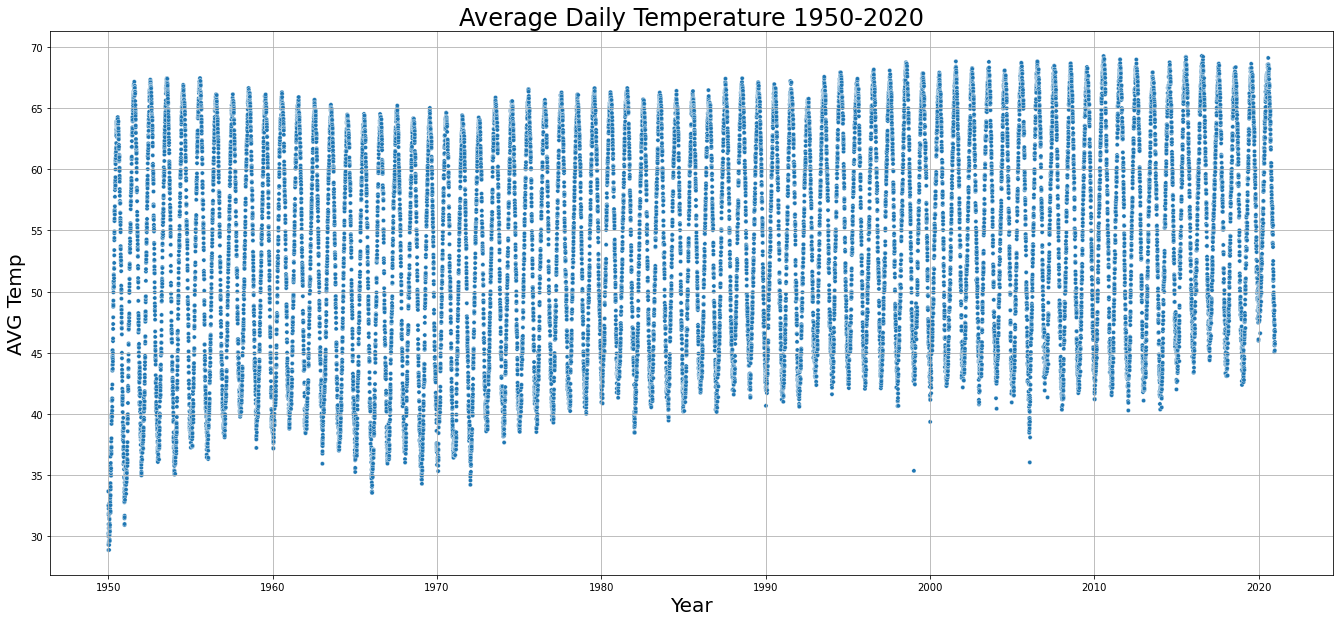

In [23]:
scat_plot(weather_df_daily.index, weather_df_daily['tavg'], weather_df_daily, 'Year', 'AVG Temp', 'Average Daily Temperature 1950-2020', figsize=(23,10))

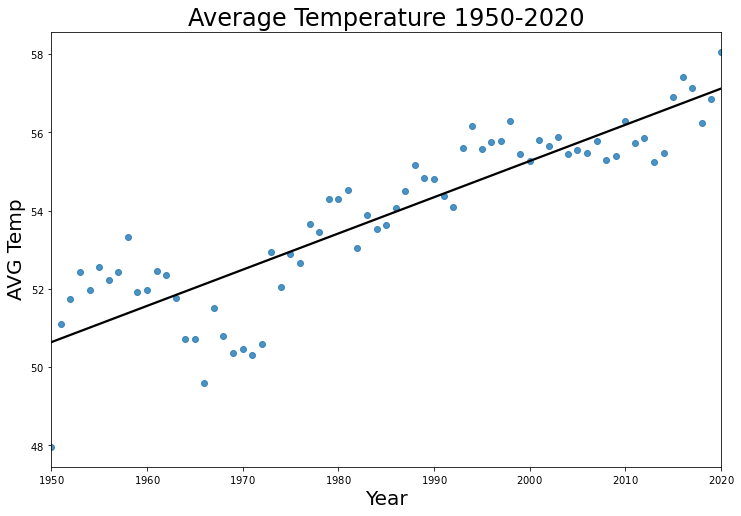

In [24]:
reg_plot(weather_df.index, weather_df['tavg'], weather_df, 'Year', 'AVG Temp', 'Average Temperature 1950-2020')

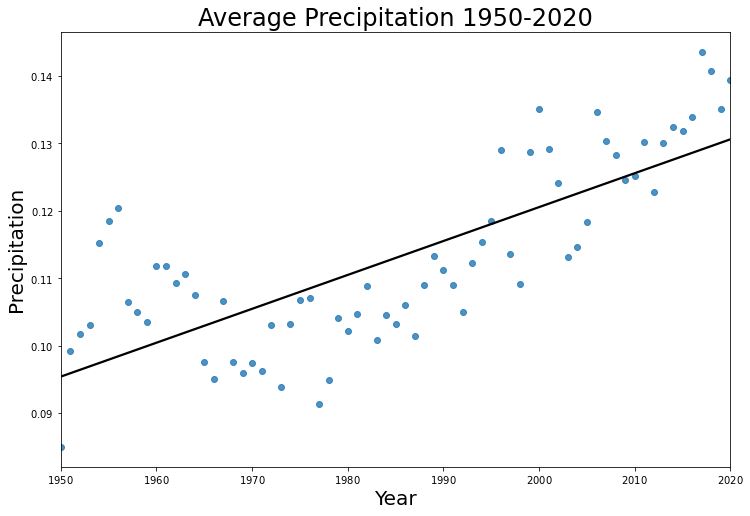

In [25]:
reg_plot(weather_df.index, weather_df['prcp'], weather_df, 'Year', 'Precipitation', 'Average Precipitation 1950-2020')

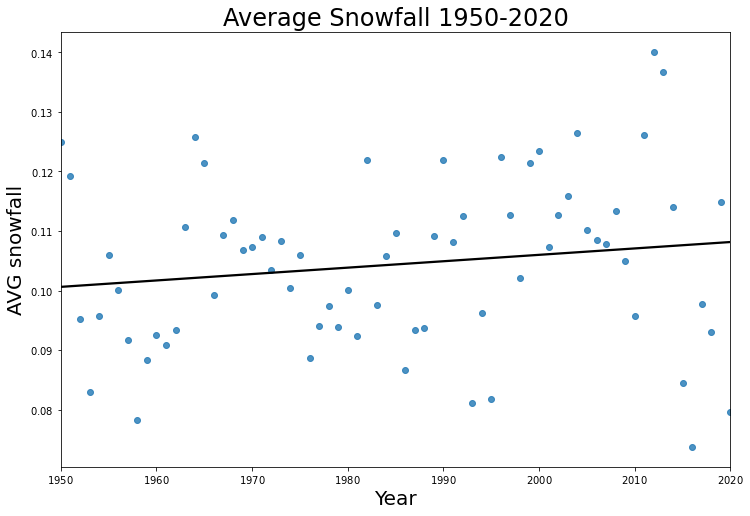

In [26]:
reg_plot(weather_df.index, weather_df['snow'], weather_df, 'Year', 'AVG snowfall', 'Average Snowfall 1950-2020')

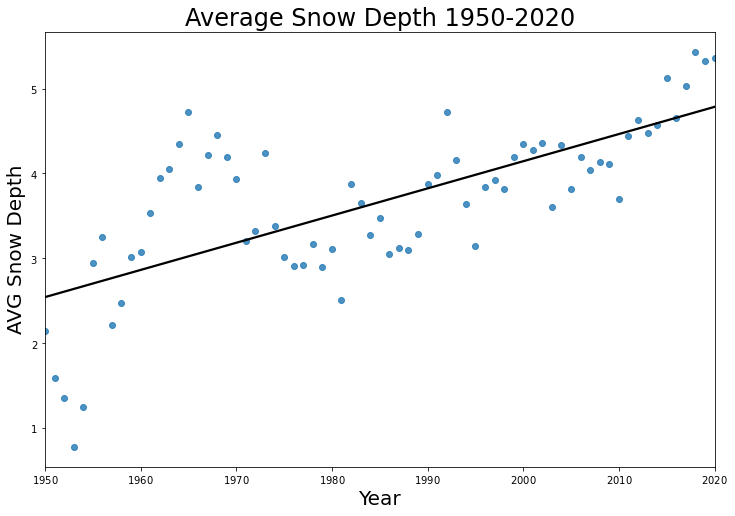

In [27]:
reg_plot(weather_df.index, weather_df['snwd'], weather_df, 'Year', 'AVG Snow Depth', 'Average Snow Depth 1950-2020')

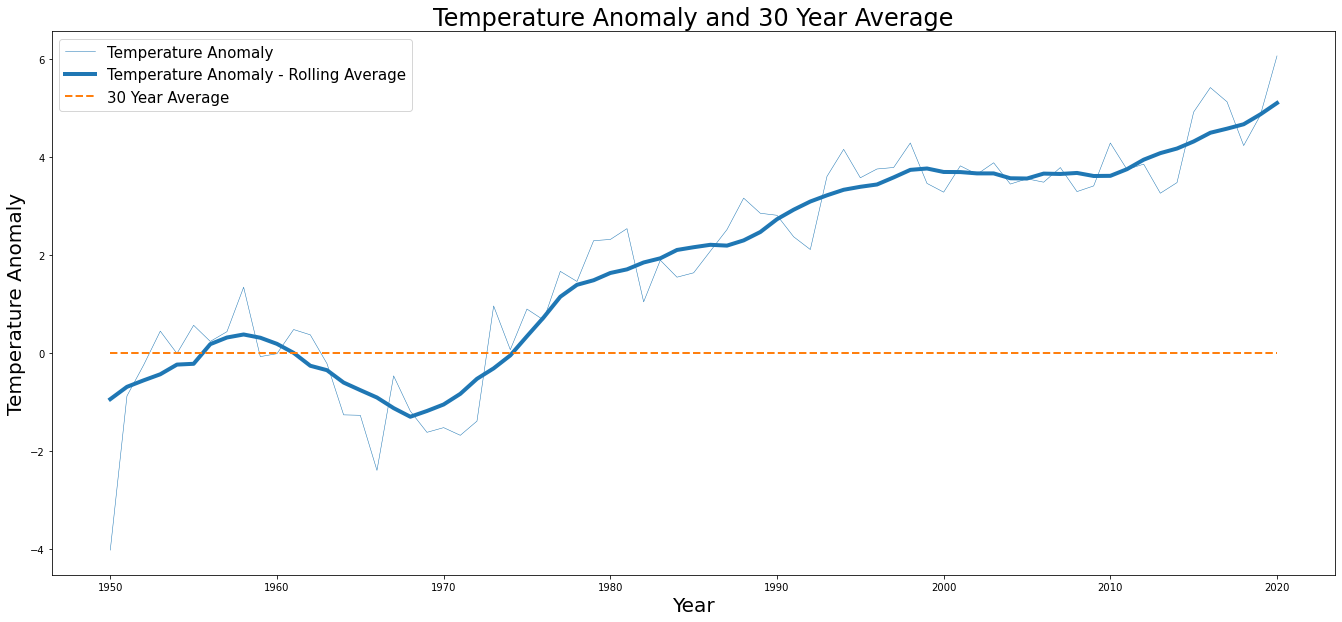

In [28]:
fig, ax = plt.subplots(figsize=(23,10))
ax.plot(weather_df.index, weather_df.tanm, color='#1f77b4', linewidth=0.5, label='Temperature Anomaly')
ax.plot(weather_df.index, weather_df.tanm.rolling(window=10, center=True, min_periods=5).mean(), color='#1f77b4', linewidth=4, label='Temperature Anomaly - Rolling Average')
ax.plot(weather_df.index, [0] * len(weather_df.index), color='#ff7f0e', linewidth=2, linestyle='dashed', label='30 Year Average')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Temperature Anomaly', fontsize=20)
ax.set_title('Temperature Anomaly and 30 Year Average', fontsize=24)
plt.legend(loc=2, prop={'size': 15})
plt.show()

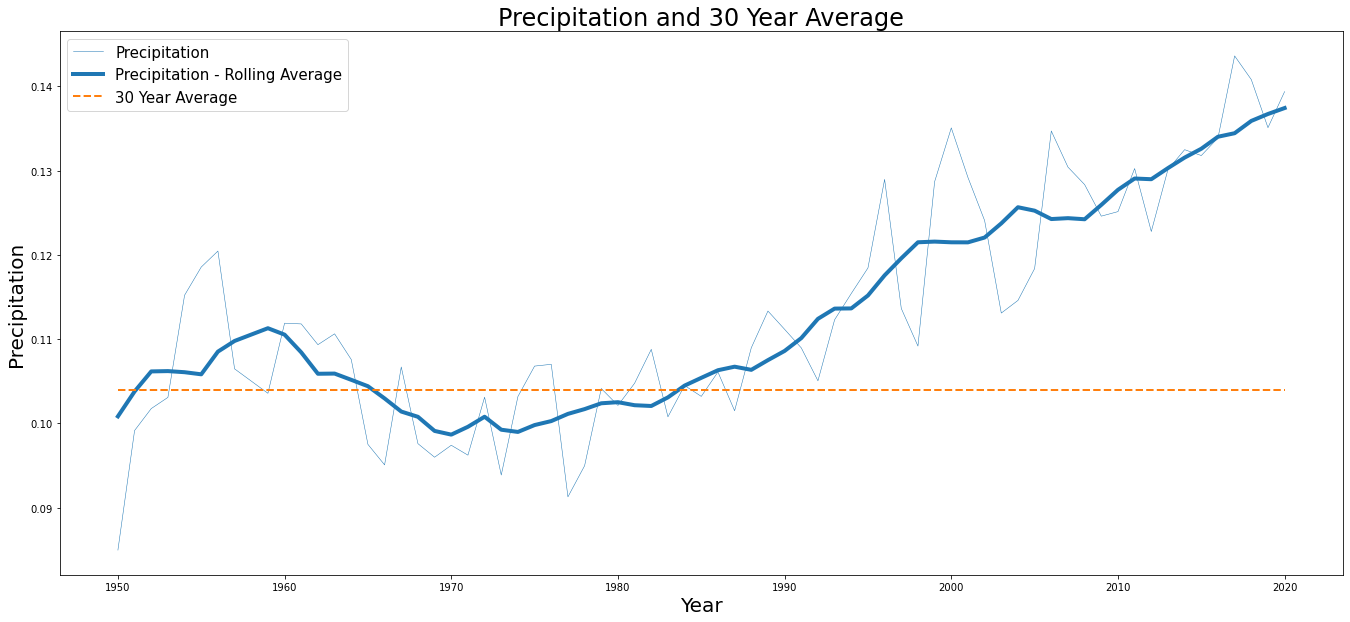

In [29]:
fig, ax = plt.subplots(figsize=(23,10))
ax.plot(weather_df.index, weather_df.prcp, color='#1f77b4', linewidth=0.5, label='Precipitation')
ax.plot(weather_df.index, weather_df.prcp.rolling(window=10, center=True, min_periods=5).mean(), color='#1f77b4', linewidth=4, label='Precipitation - Rolling Average')
ax.plot(weather_df.index, [precip_average] * len(weather_df.index), color='#ff7f0e', linewidth=2, linestyle='dashed', label='30 Year Average')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Precipitation', fontsize=20)
ax.set_title('Precipitation and 30 Year Average', fontsize=24)
plt.legend(loc=2, prop={'size': 15})
plt.show()

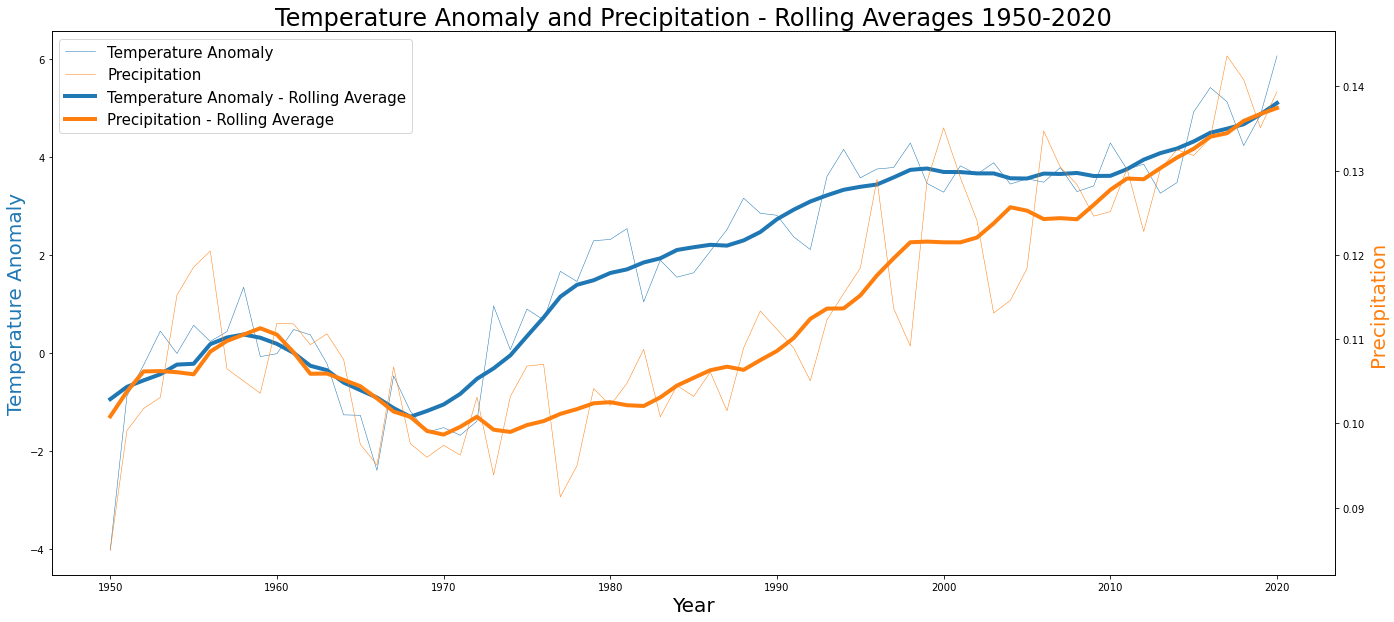

In [30]:
fig, ax = plt.subplots(figsize = (23, 10))
ax2 = ax.twinx()

line1 = ax.plot(weather_df.index, weather_df.tanm, color='#1f77b4', linewidth=0.5, label='Temperature Anomaly')
line2 = ax2.plot(weather_df.index, weather_df.prcp, color='#ff7f0e', linewidth=0.5, label='Precipitation')
line3 = ax.plot(weather_df.index, weather_df.tanm.rolling(window=10, center=True, min_periods=5).mean(), color='#1f77b4', linewidth=4, label='Temperature Anomaly - Rolling Average')
line4 = ax2.plot(weather_df.index, weather_df.prcp.rolling(window=10, center=True, min_periods=5).mean(), color='#ff7f0e', linewidth=4, label='Precipitation - Rolling Average')

lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]

plt.title('Temperature Anomaly and Precipitation - Rolling Averages 1950-2020', fontsize = 24)
ax.set_xlabel('Year', fontsize = 20)
ax.set_ylabel('Temperature Anomaly', fontsize = 20, color = '#1f77b4')
ax2.set_ylabel('Precipitation', fontsize = 20, color = '#ff7f0e')
ax.legend(lines, labels, loc = 2, prop = {'size': 15})

plt.show()

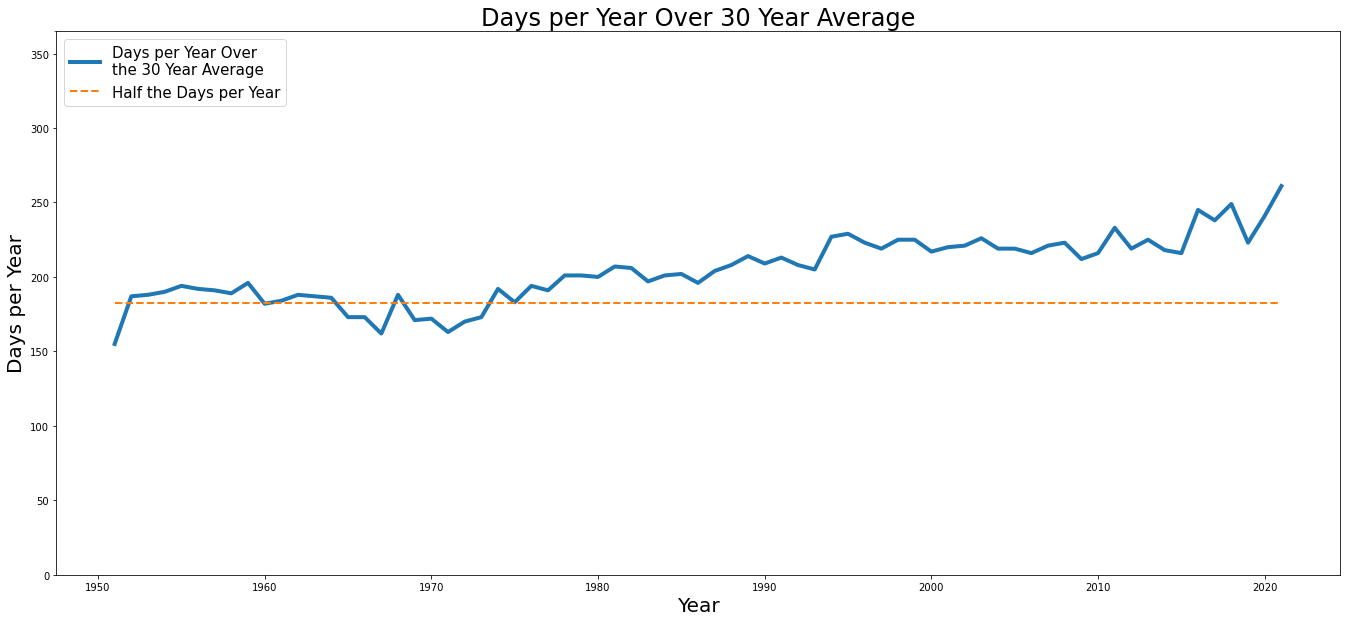

In [31]:
weather_df_daily.index = pd.to_datetime(weather_df_daily.index)
df = weather_df_daily[weather_df_daily['tanm'] > 0]['tanm'].resample('A').count()

fig, ax = plt.subplots(figsize=(23,10))
ax.plot(df.index, df, linewidth=4, label='Days per Year Over\nthe 30 Year Average')
ax.plot(df.index, [182.5] * len(df.index), linewidth=2, linestyle='dashed', label='Half the Days per Year')
ax.set_yticks([0, 365], minor=True)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Days per Year', fontsize=20)
ax.set_title('Days per Year Over 30 Year Average', fontsize=24)
plt.legend(loc=2, prop={'size': 15})
plt.show()

## Explore Disaster Data

### <u>Disaster types</u>

Epidemic: A widespread occurrence of an infectious disease<br>
Flood: An overflow of water that submerges land that is usually dry<br>
Volcanic activity: Emission of gases, non-explosive lava to extremely violent explosive bursts<br>
Earthquake: The shaking of the surface of the Earth resulting from a sudden release of energy in the Earth's lithosphere that creates seismic waves<br>
Storm: Significant disruptions to normal conditions such as strong wind, tornadoes, hail, thunder and lightning, heavy precipitation, heavy freezing rain, strong winds, or wind transporting some substance through the atmosphere<br>
Drought: A deficiency in precipitation over an extended period<br>
Mass movement (dry): The geomorphic process by which soil, sand, regolith, and rock move downslope<br>
Landslide: Mass movement that involves heavy precipitation<br>
Wildfire: An unplanned, unwanted, uncontrolled fire in an area of combustible vegetation<br>
Insect infestation: The pervasive influx, swarming and/or hatching of insects affecting humans, animals, crops, and perishable goods<br>
Complex Disasters: A form of human-made emergency in which the cause of the emergency as well as the assistance to the afflicted are bound by intense levels of political considerations<br>
Extreme temperature: Temperatures that hover 10 degrees or more above/below the average high/low temperature for the region and last for several weeks<br>
Fog: A visible aerosol consisting of tiny water droplets or ice crystals suspended in the air at or near the Earth's surface<br>
Impact: Asteroids or other astrophysical formations that make contact with the Earth<br>
Animal accident: Displacement from other disasters, major outbreaks of disease and parasite infestations, malnutrition and starvation due to limited food supplies and exposure to sun, cold, or wind

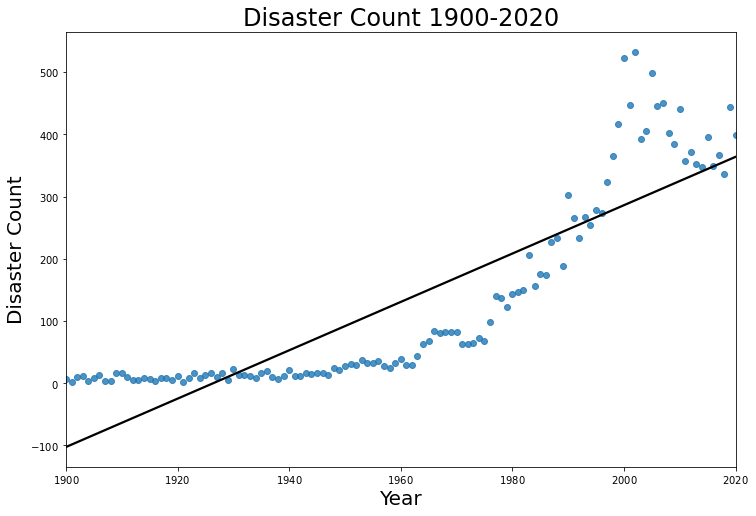

In [32]:
reg_plot(disaster_df_yearly.index, disaster_df_yearly['count'], disaster_df_yearly, 'Year', 'Disaster Count', 'Disaster Count 1900-2020')

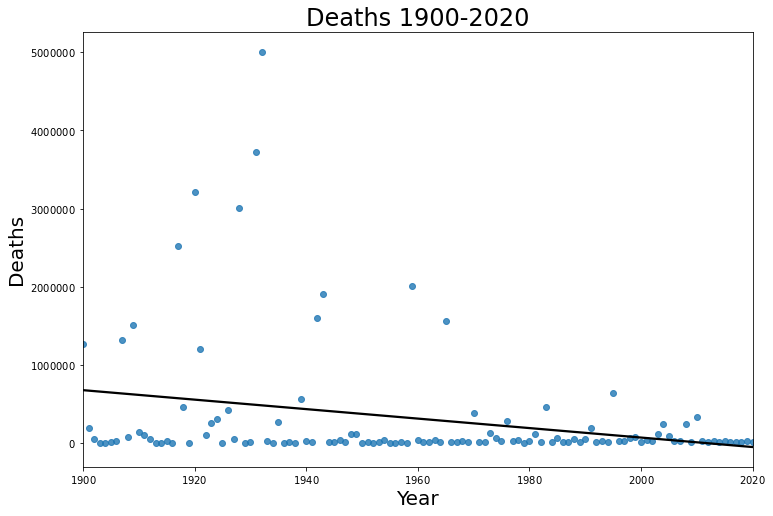

In [33]:
reg_plot(disaster_df_yearly.index, disaster_df_yearly['deaths'], disaster_df_yearly, 'Year', 'Deaths', 'Deaths 1900-2020')

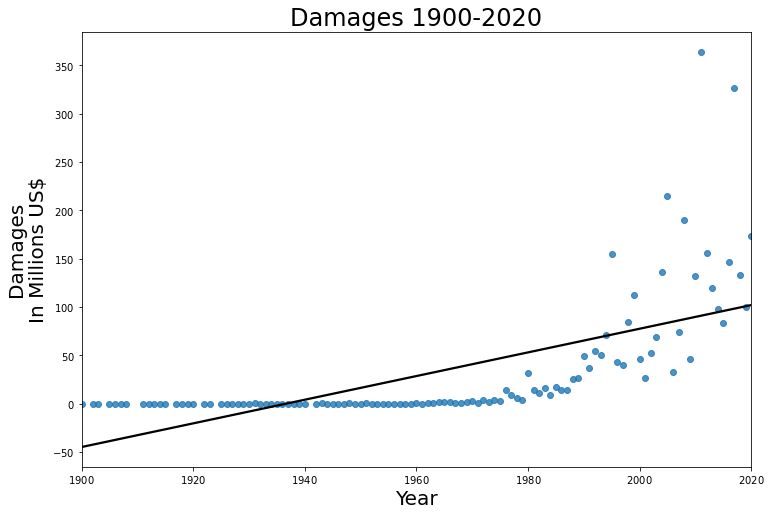

In [34]:
reg_plot(disaster_df_yearly.index, disaster_df_yearly['damages']//1000000, disaster_df_yearly, 'Year', 'Damages\nIn Millions US$', 'Damages 1900-2020')

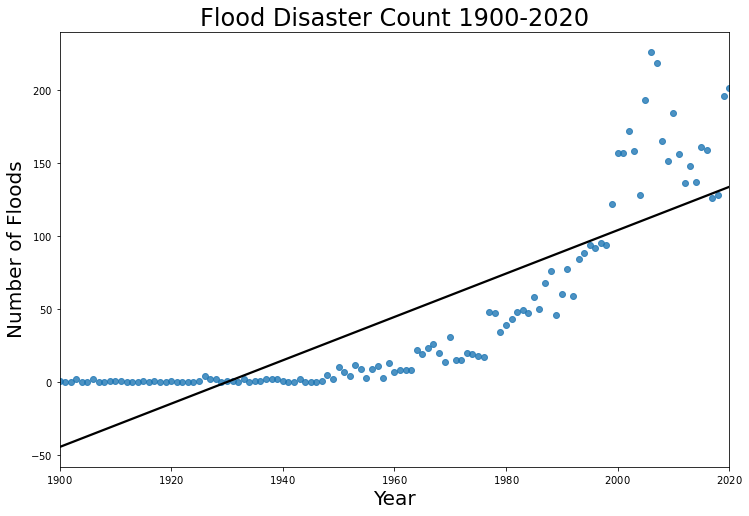

In [35]:
reg_plot(disaster_df_type.index, disaster_df_type['Flood'], disaster_df_type, 'Year', 'Number of Floods', 'Flood Disaster Count 1900-2020')

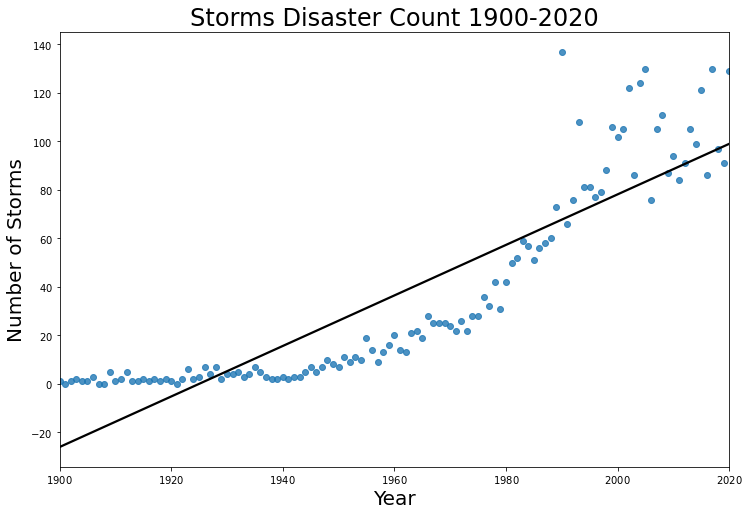

In [36]:
reg_plot(disaster_df_type.index, disaster_df_type['Storm'], disaster_df_type, 'Year', 'Number of Storms', 'Storms Disaster Count 1900-2020')

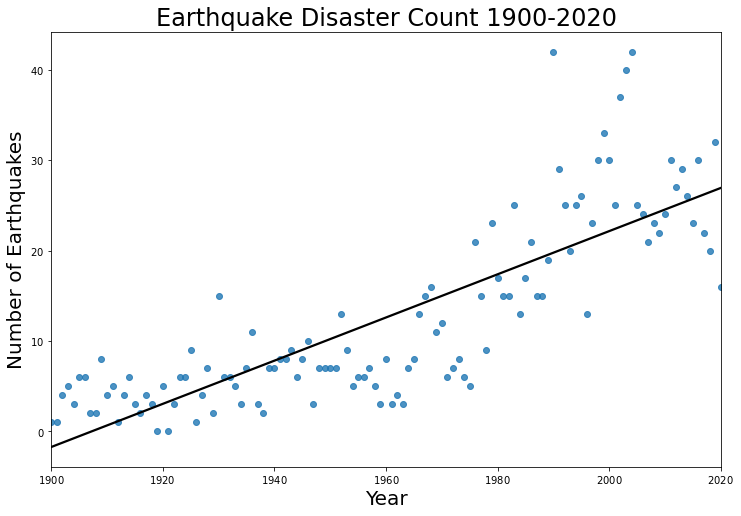

In [37]:
reg_plot(disaster_df_type.index, disaster_df_type['Earthquake'], disaster_df_type, 'Year', 'Number of Earthquakes', 'Earthquake Disaster Count 1900-2020')

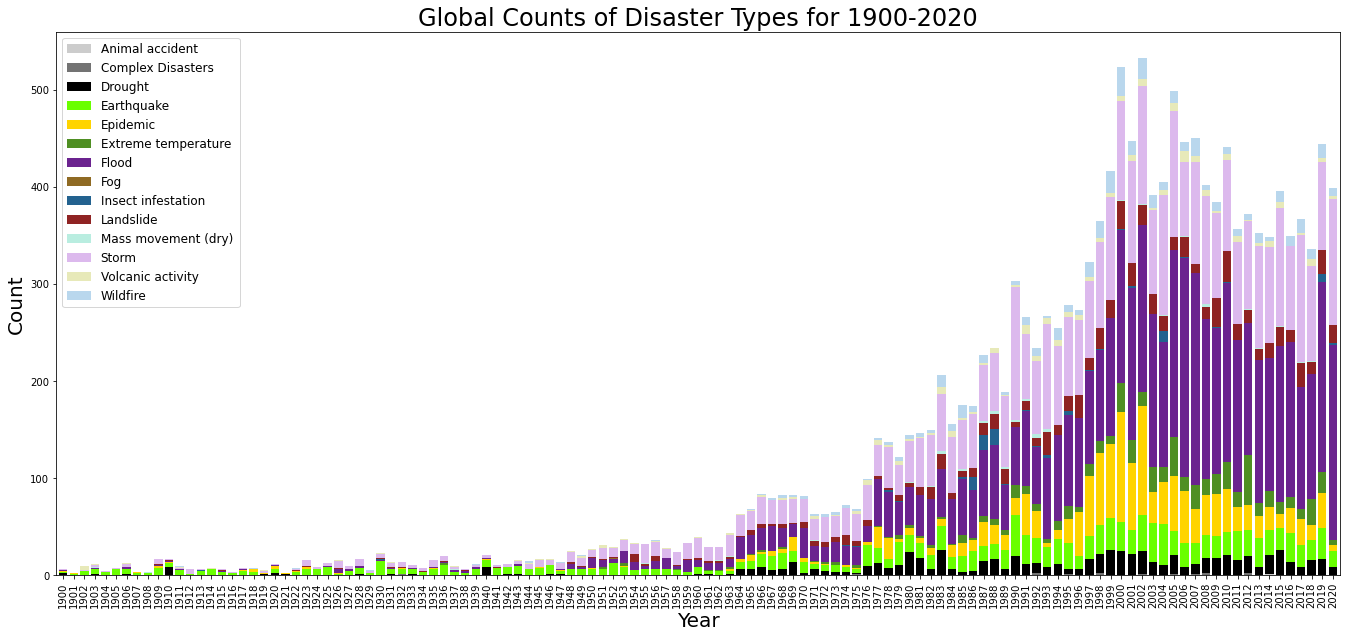

In [26]:
bar_stack_plot(disaster_df_type, 'Year', 'Count', 'Global Counts of Disaster Types for 1900-2020')

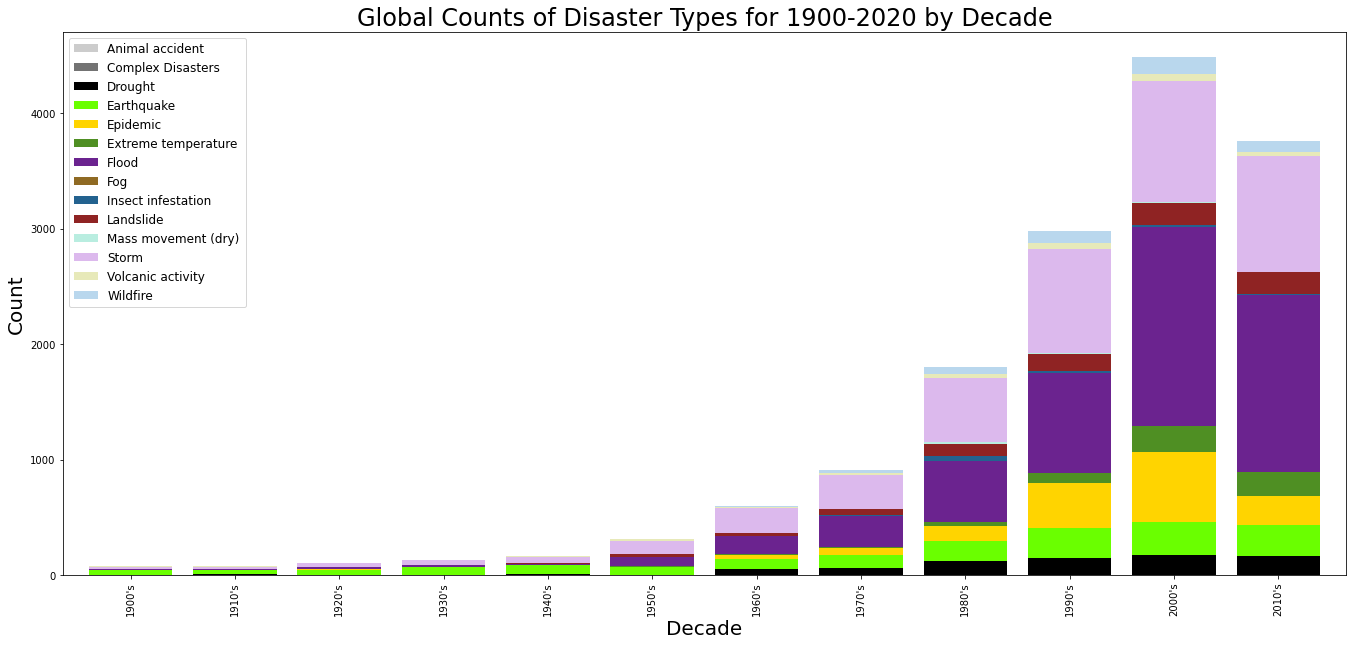

In [27]:
bar_stack_decade_plot(disaster_df_type, 'Decade', 'Count', 'Global Counts of Disaster Types for 1900-2020 by Decade')

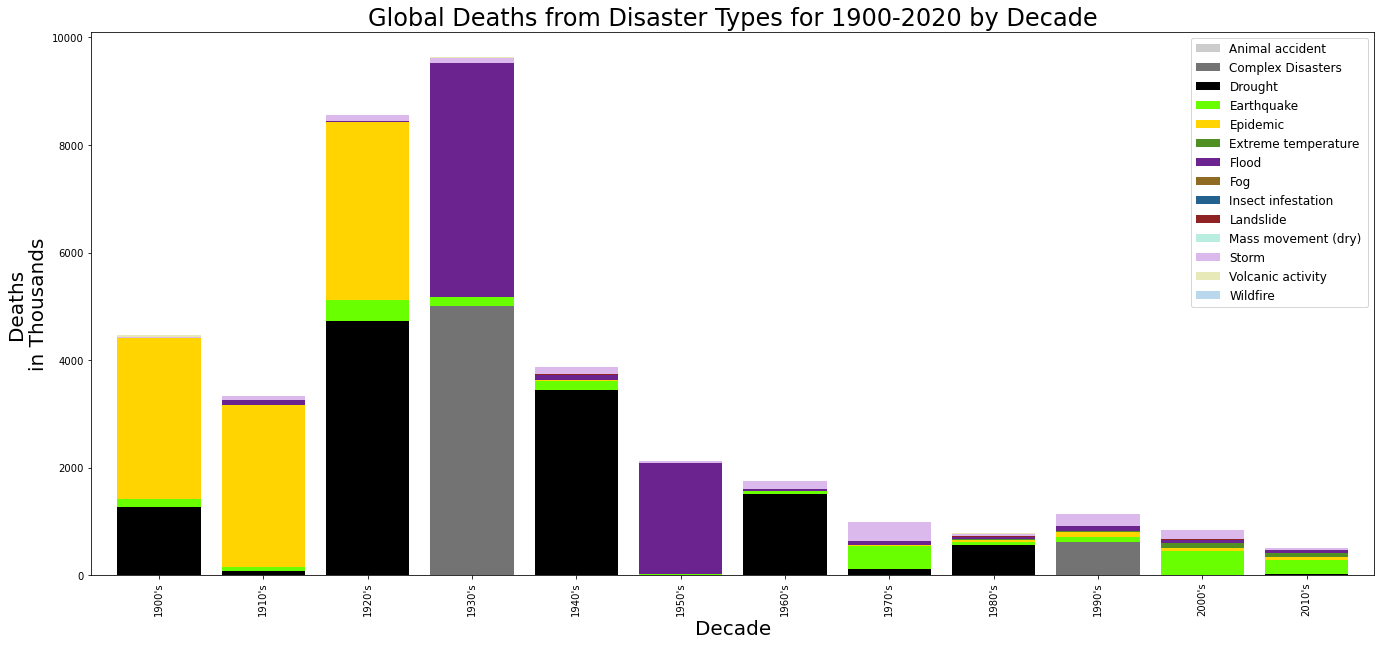

In [28]:
bar_stack_decade_plot(disaster_df_death_type, 'Decade', 'Deaths\nin Thousands', 'Global Deaths from Disaster Types for 1900-2020 by Decade', y_divide=1000)

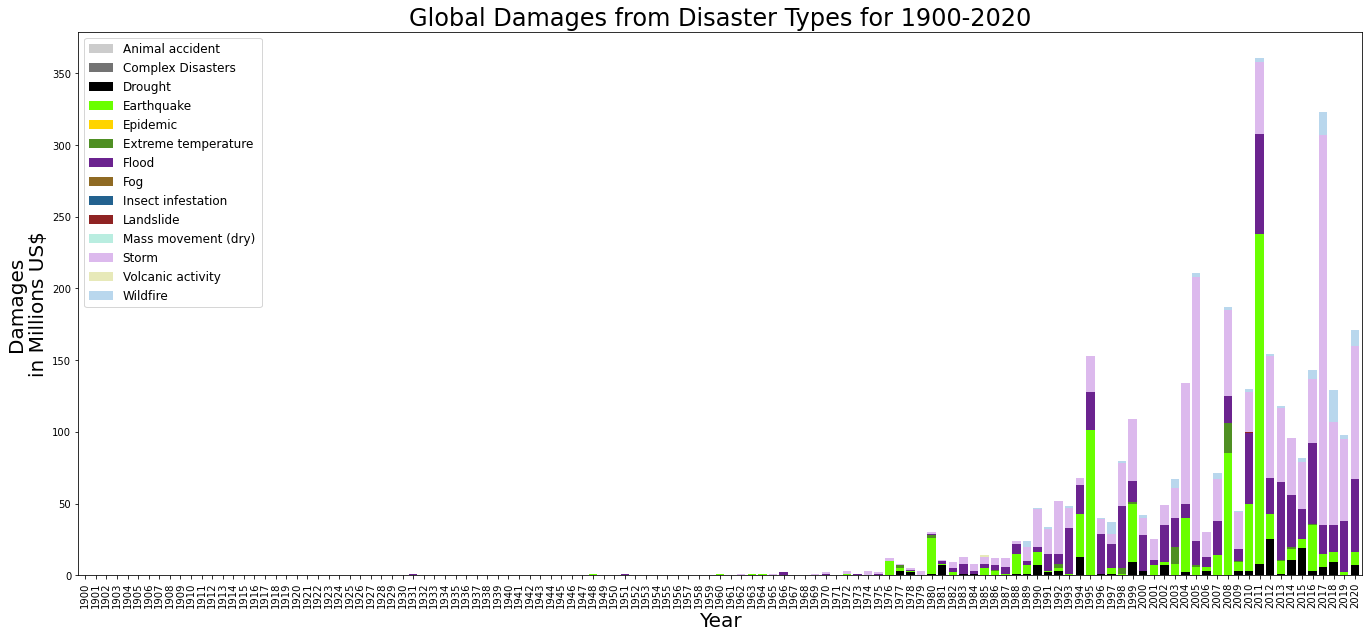

In [35]:
bar_stack_plot(disaster_df_damages_type, 'Year', 'Damages\nin Millions US$', 'Global Damages from Disaster Types for 1900-2020', y_divide=1000000)

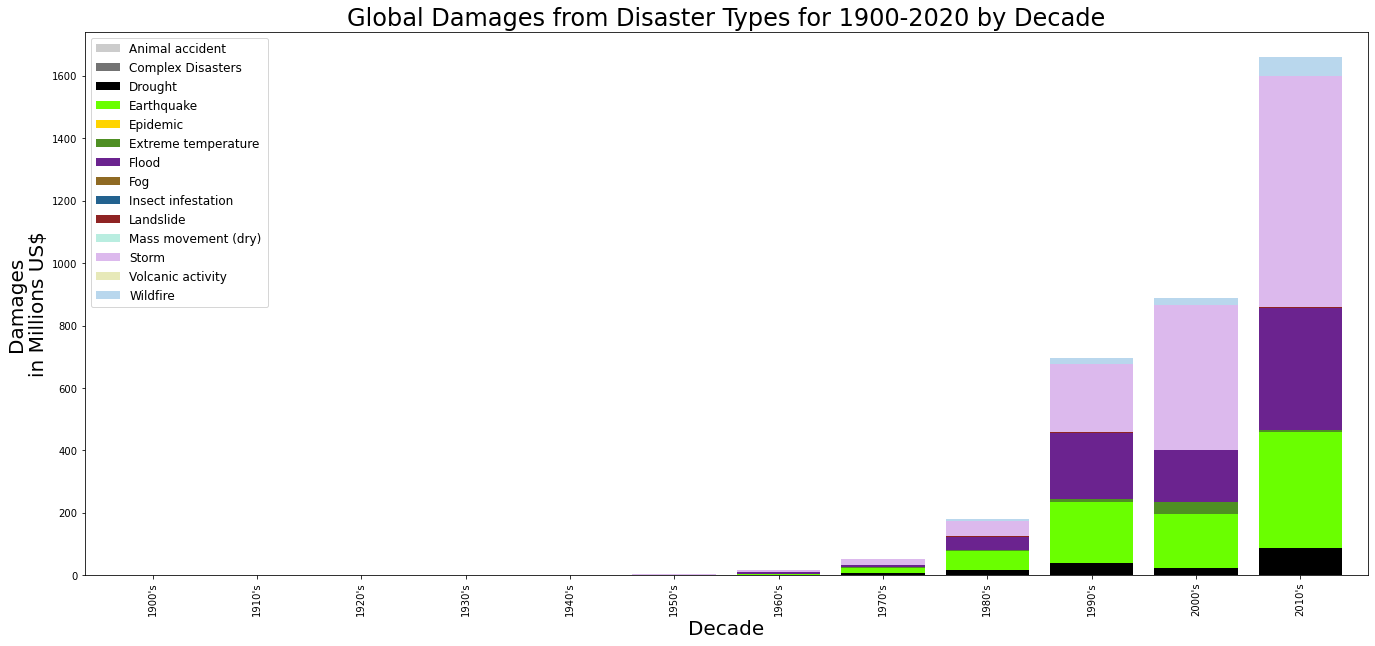

In [30]:
bar_stack_decade_plot(disaster_df_damages_type, 'Decade', 'Damages\nin Millions US$', 'Global Damages from Disaster Types for 1900-2020 by Decade', y_divide=1000000)

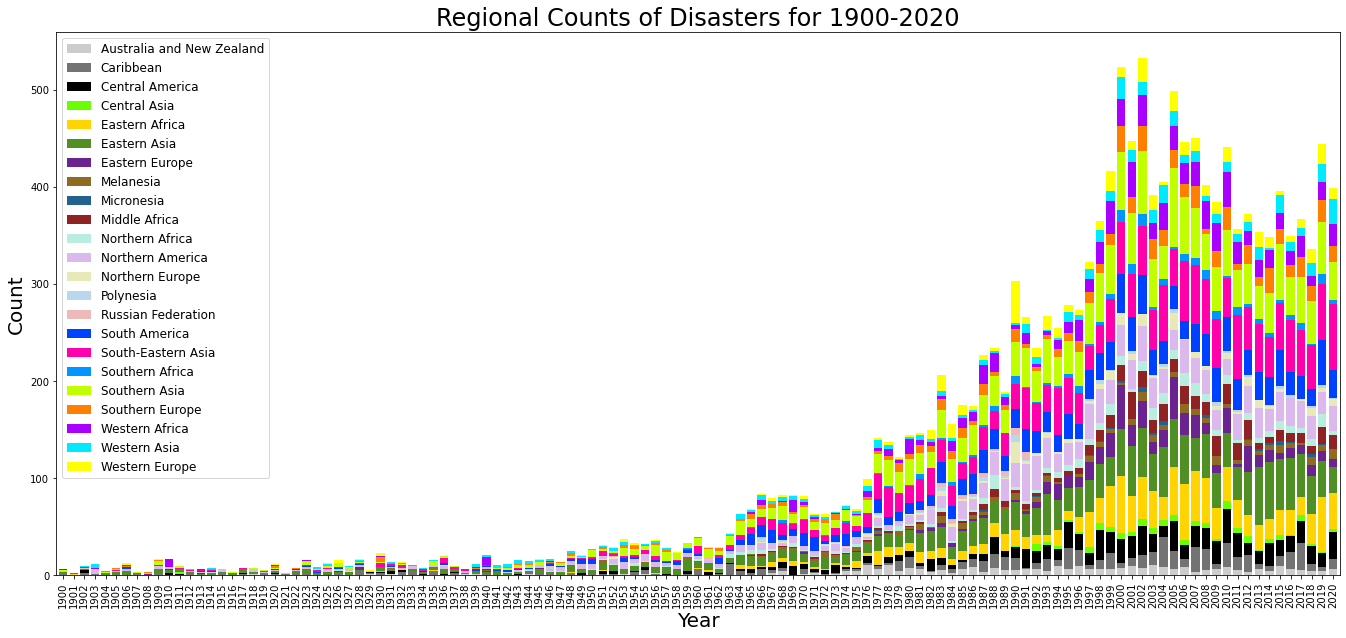

In [31]:
bar_stack_plot(disaster_df_region, 'Year', 'Count', 'Regional Counts of Disasters for 1900-2020')

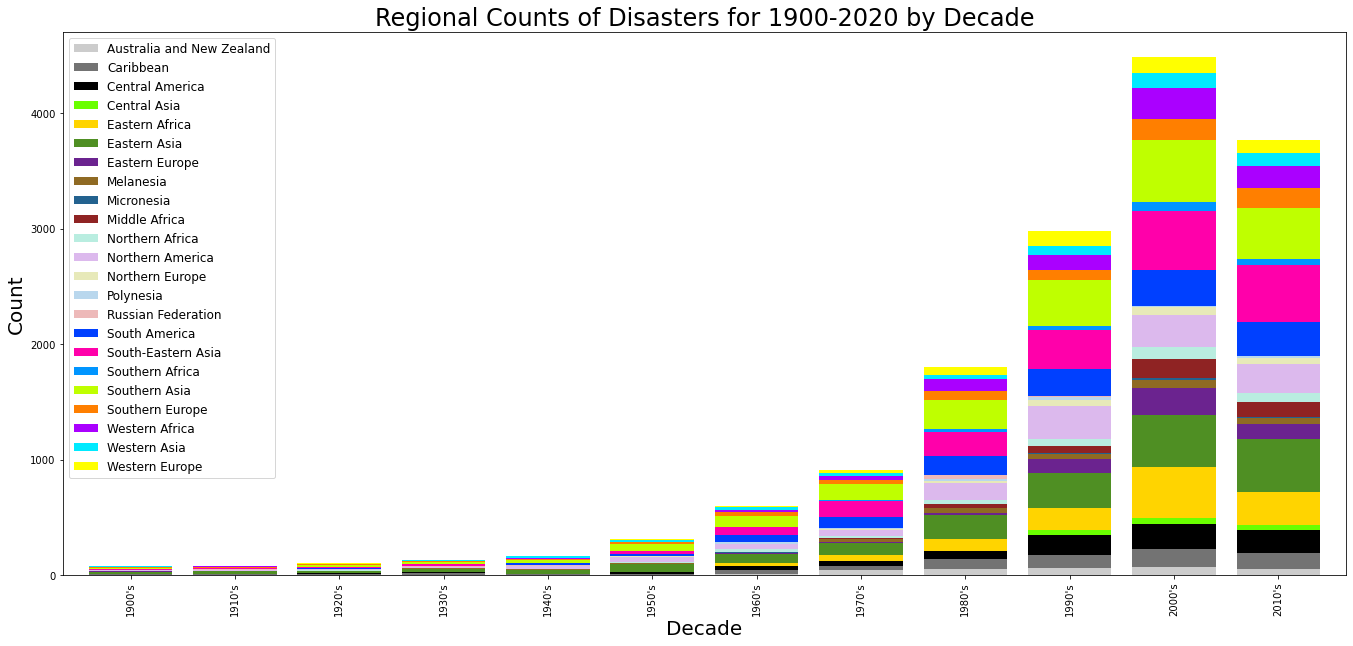

In [32]:
bar_stack_decade_plot(disaster_df_region, 'Decade', 'Count', 'Regional Counts of Disasters for 1900-2020 by Decade')

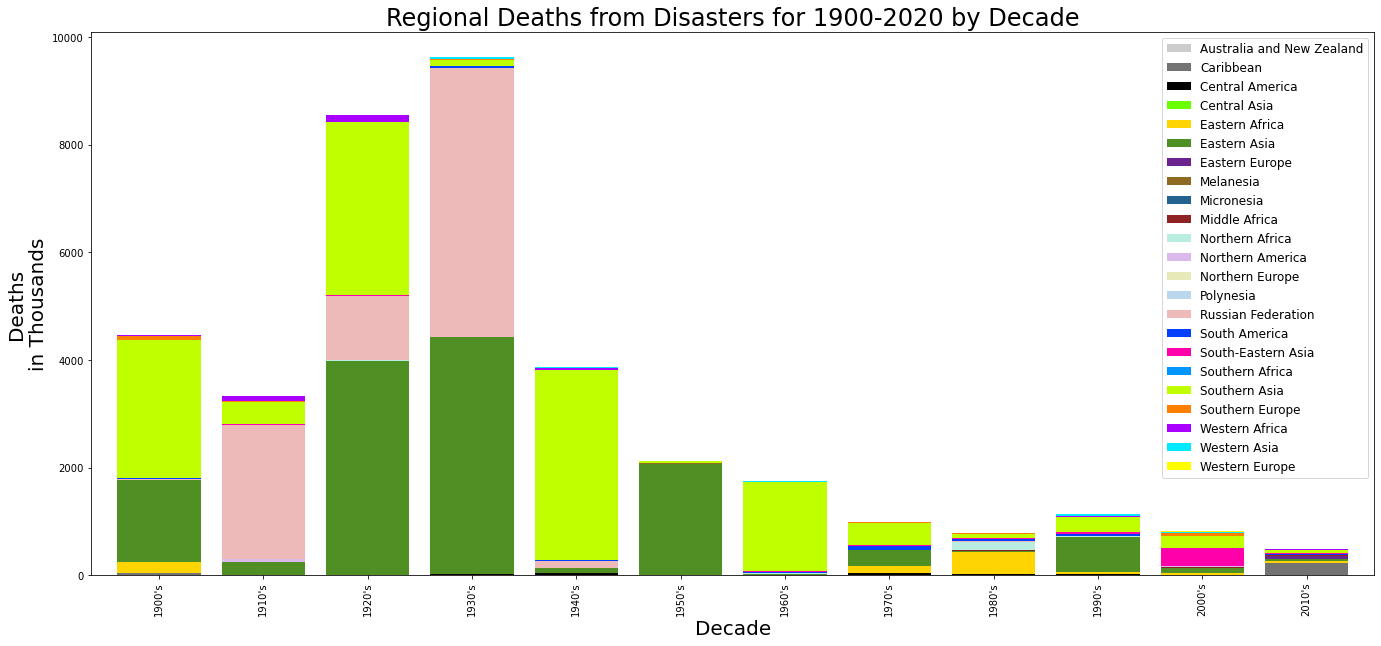

In [33]:
bar_stack_decade_plot(disaster_df_death_region, 'Decade', 'Deaths\nin Thousands', 'Regional Deaths from Disasters for 1900-2020 by Decade', y_divide=1000)

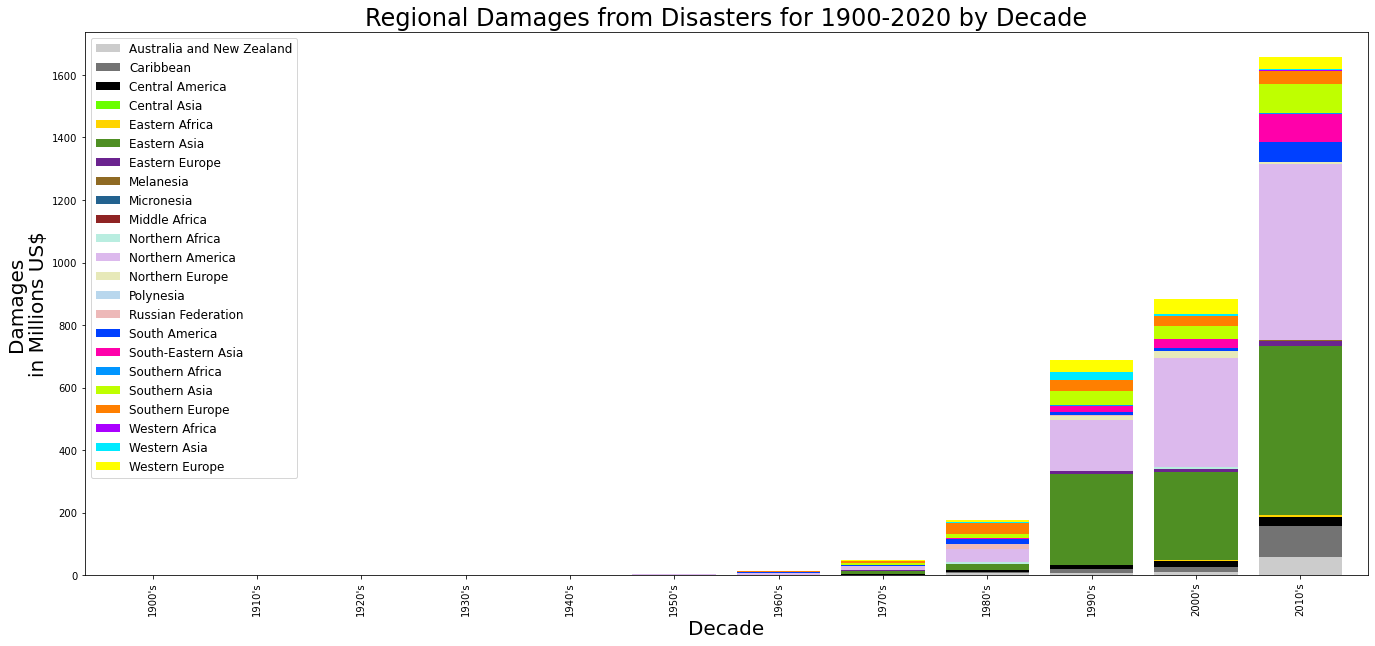

In [34]:
bar_stack_decade_plot(disaster_df_damages_region, 'Decade', 'Damages\nin Millions US$', 'Regional Damages from Disasters for 1900-2020 by Decade', y_divide=1000000)

## Correlations Between Weather and Disasters

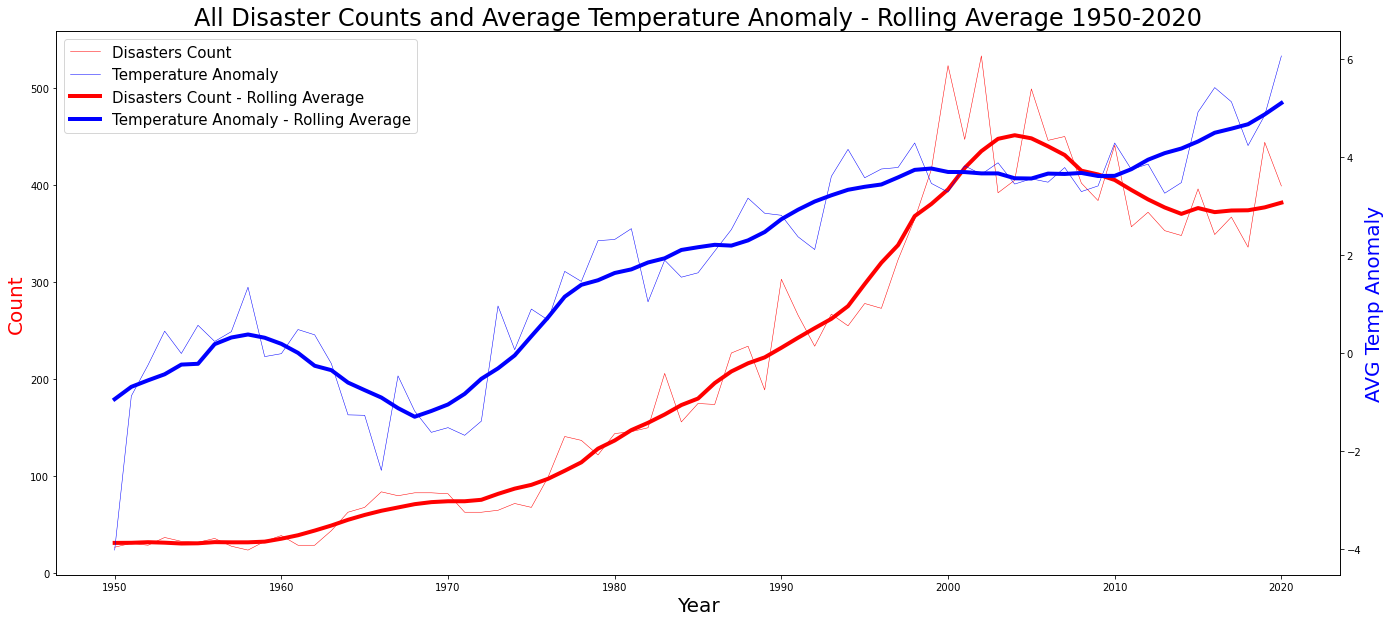

In [47]:
fig, ax = plt.subplots(figsize = (23, 10))
ax2 = ax.twinx()

line1 = ax.plot(disaster_df_yearly.loc[1950:2020, 'count'], '-r', linewidth=0.5, label = 'Disasters Count')
line2 = ax2.plot(weather_df.loc[1950:, 'tanm'], '-b', linewidth=0.5, label = 'Temperature Anomaly')
line3 = ax.plot(disaster_df_yearly.loc[1950:2020, 'count'].rolling(window=10, center=True, min_periods=5).mean(), '-r', linewidth=4, label = 'Disasters Count - Rolling Average')
line4 = ax2.plot(weather_df.loc[1950:, 'tanm'].rolling(window=10, center=True, min_periods=5).mean(), '-b', linewidth=4, label = 'Temperature Anomaly - Rolling Average')

lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]

plt.title('All Disaster Counts and Average Temperature Anomaly - Rolling Average 1950-2020', fontsize = 24)
ax.set_xlabel('Year', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20, color = 'r')
ax2.set_ylabel('AVG Temp Anomaly', fontsize = 20, color = 'b')
ax.legend(lines, labels, loc = 2, prop = {'size': 15})

plt.show()

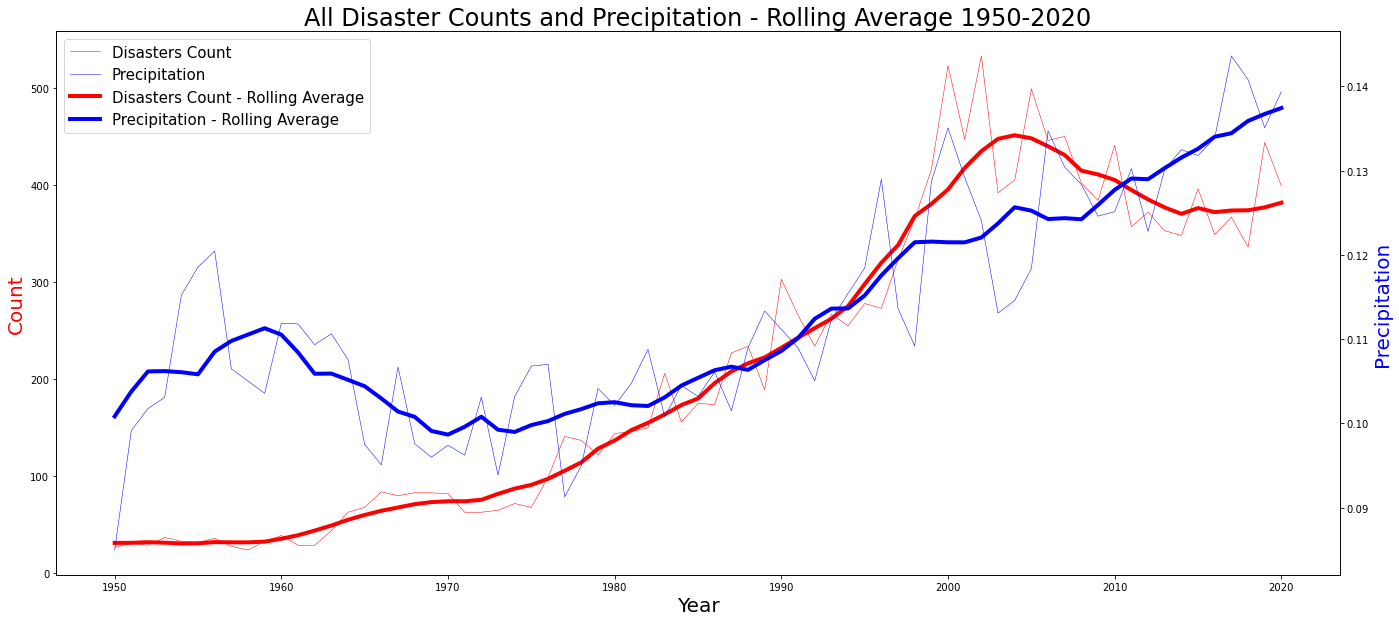

In [48]:
fig, ax = plt.subplots(figsize = (23, 10))
ax2 = ax.twinx()

line1 = ax.plot(disaster_df_yearly.loc[1950:2020, 'count'], '-r', linewidth=0.5, label = 'Disasters Count')
line2 = ax2.plot(weather_df.loc[1950:, 'prcp'], '-b', linewidth=0.5, label = 'Precipitation')
line3 = ax.plot(disaster_df_yearly.loc[1950:2020, 'count'].rolling(window=10, center=True, min_periods=5).mean(), '-r', linewidth=4, label = 'Disasters Count - Rolling Average')
line4 = ax2.plot(weather_df.loc[1950:, 'prcp'].rolling(window=10, center=True, min_periods=5).mean(), '-b', linewidth=4, label = 'Precipitation - Rolling Average')

lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]

plt.title('All Disaster Counts and Precipitation - Rolling Average 1950-2020', fontsize = 24)
ax.set_xlabel('Year', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20, color = 'r')
ax2.set_ylabel('Precipitation', fontsize = 20, color = 'b')
ax.legend(lines, labels, loc = 2, prop = {'size': 15})

plt.show()

In [49]:
# Merge both sets of data for correlation table

combined = pd.merge(weather_df, disaster_df_yearly.loc[1950:], on='year')
combined.drop(['tmin','tmax','tavg'], inplace=True, axis=1)
combined.head()

,prcp,snow,snwd,tanm,count,deaths,damages
year,,,,,,,
1950,0.084971,0.124971,2.138802,-4.027794,27,6845,226000.0
1951,0.099155,0.119240,1.586048,-0.877544,31,18227,1528250.0
1952,0.101761,0.095212,1.360583,-0.246030,29,6886,142900.0
1953,0.103087,0.082973,0.777744,0.447789,37,12997,987880.0
1954,0.115209,0.095816,1.254132,-0.009104,33,41847,890150.0


In [50]:
# Correlation table

corr_table = combined.corr()
corr_table

,prcp,snow,snwd,tanm,count,deaths,damages
prcp,1.000000,0.068810,0.556226,0.767924,0.751792,-0.159048,0.671509
snow,0.068810,1.000000,0.287144,-0.082475,0.239565,-0.057539,0.145760
snwd,0.556226,0.287144,1.000000,0.476559,0.599485,0.012278,0.490752
tanm,0.767924,-0.082475,0.476559,1.000000,0.843000,-0.153589,0.652337
count,0.751792,0.239565,0.599485,0.843000,1.000000,-0.123938,0.665612
deaths,-0.159048,-0.057539,0.012278,-0.153589,-0.123938,1.000000,-0.048817
damages,0.671509,0.145760,0.490752,0.652337,0.665612,-0.048817,1.000000


In [51]:
# Feature correlation for number of disasters

corr_table['count'].sort_values(ascending=False)

count      1.000000
tanm       0.843000
prcp       0.751792
damages    0.665612
snwd       0.599485
snow       0.239565
deaths    -0.123938
Name: count, dtype: float64

In [52]:
# Feature correlation for number of deaths

corr_table['deaths'].sort_values(ascending=False)

deaths     1.000000
snwd       0.012278
damages   -0.048817
snow      -0.057539
count     -0.123938
tanm      -0.153589
prcp      -0.159048
Name: deaths, dtype: float64

In [53]:
# Feature correlation for amount of damages

corr_table['damages'].sort_values(ascending=False)

damages    1.000000
prcp       0.671509
count      0.665612
tanm       0.652337
snwd       0.490752
snow       0.145760
deaths    -0.048817
Name: damages, dtype: float64

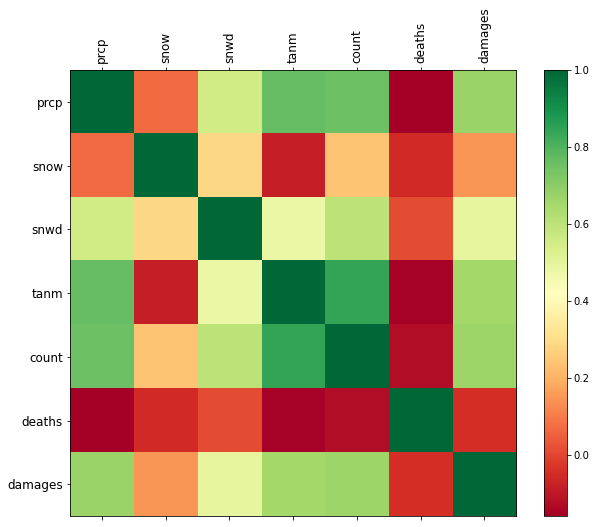

In [54]:
# Correlation heatmap

fig, ax = plt.subplots(figsize = (10, 10))

labels = [name for name in corr_table.columns]
cax = ax.matshow(corr_table, cmap = 'RdYlGn')
cbar = fig.colorbar(cax, shrink = 0.82)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize = 12, rotation = 'vertical')
ax.set_yticklabels(labels, fontsize = 12)
ax.grid(False)

plt.show()

## Conclusion

There is clear evidence that the earth is warming, and levels of precipitation are on the rise. These are strongly correlated. The number of disasters is also strongly correlated to temperature and precipitation change. Deaths have been going down, despite the numbers of natural disasters going up. Damages due to disasters are also moderately correlated with climate change. If the temperature continues to rise, we will see an increase in the number of natural disasters, and as a result, more damages.